# **KGFarm**
**A Feature Discovery system for Machine learning workflows**
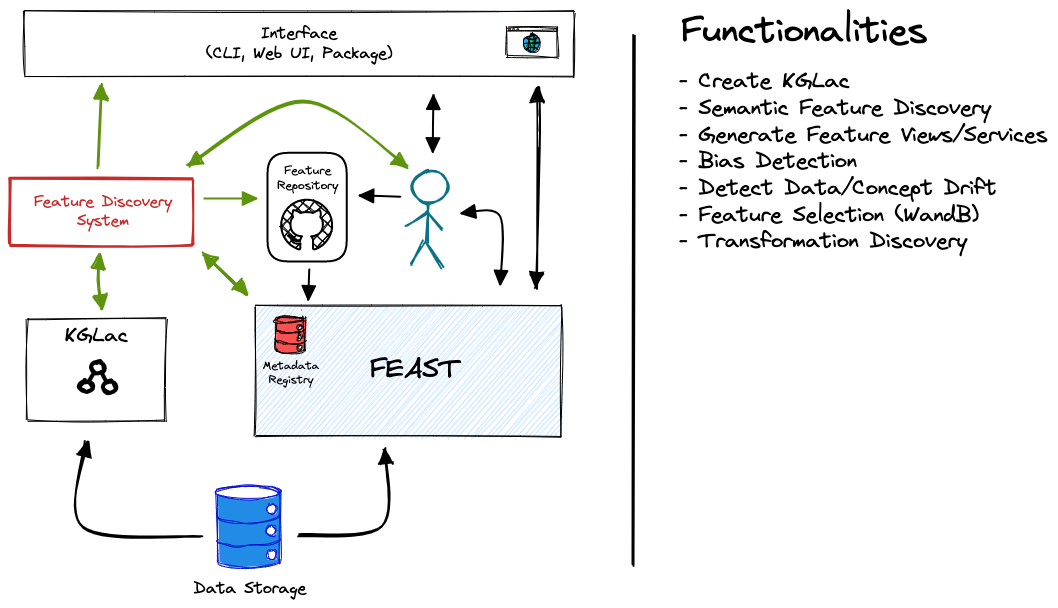






In [1]:
from feature_discovery.src.api.api import KGFarm
kgfarm = KGFarm()

connected to Stardog!
Access the Stardog UI at: https://cloud.stardog.com/




1.   **Predicting [Feature Views](https://docs.feast.dev/getting-started/concepts/feature-view)**
  *   To modify the path to the feature repo, pass the updated path to the instance of KGFarm
  *   To see the predicted feature views, set <code>show_feature_views = True</code>







In [2]:
kgfarm.predict_feature_views(ttl=30, show_feature_views=True)

Predicted entities and feature view(s) File saved at:  /Users/shubhamvashisth/Documents/CoDS/projects/KGFarm/feature_repo/predicted_register.py



,Feature_view,Entity,Entity_data_type,Time_to_leave,File_source,File_source_path,Dataset
0,feature_view_1,district_id,INT64,30,completeddistrict.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata
1,feature_view_2,account_id,STRING,30,completedacct.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata
2,feature_view_3,client_id,INT64,30,completeddisposition.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata


## **Using Discovery operations**

In [3]:
import os
import sys
import pandas as pd
sys.path.append('../data_discovery/knowledge_graph/src/')
from api.api import *
from storage.kglac_client import KGLacClient
from storage.elasticsearch_client import ElasticsearchClient
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
kglac = API(ElasticsearchClient(), KGLacClient('glac')) 

   
**Table search (using KGLac)** 


In [4]:
df = kglac.search_tables_on([['district']])
df

,table_name,dataset_name,origin,number_of_columns,number_of_rows,path
0,completedclient.parquet,retail-bankingdemodata,mock,21.0,5369.0,/Users/shubhamvashisth/Documents/CoDS/projects...
1,completedacct.parquet,retail-bankingdemodata,mock,9.0,4500.0,/Users/shubhamvashisth/Documents/CoDS/projects...
2,crm_reviews.parquet,retail-bankingdemodata,mock,6.0,505.0,/Users/shubhamvashisth/Documents/CoDS/projects...
3,district.parquet,retail-bankingdemodata,mock,2.0,100.0,/Users/shubhamvashisth/Documents/CoDS/projects...
4,completeddistrict.parquet,retail-bankingdemodata,mock,11.0,77.0,/Users/shubhamvashisth/Documents/CoDS/projects...


2.   **Searching for enrichable tables** 

In [5]:
enrichment_info = kgfarm.get_enrichable_tables()
enrichment_info

,Table,Enrich_with,Path_to_table,File_source_path,File_source,Dataset,Dataset_feature_view
0,crm_reviews.parquet,feature_view_1,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,completeddistrict.parquet,retail-bankingdemodata,retail-bankingdemodata
1,district.parquet,feature_view_1,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,completeddistrict.parquet,retail-bankingdemodata,retail-bankingdemodata
3,completeddisposition.parquet,feature_view_2,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,completedacct.parquet,retail-bankingdemodata,retail-bankingdemodata
4,completedorder.parquet,feature_view_2,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,completedacct.parquet,retail-bankingdemodata,retail-bankingdemodata
5,account.parquet,feature_view_2,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,completedacct.parquet,retail-bankingdemodata,retail-bankingdemodata
2,crm_call_center_logs.parquet,feature_view_3,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,completeddisposition.parquet,retail-bankingdemodata,retail-bankingdemodata


**Path between joinable tables** 

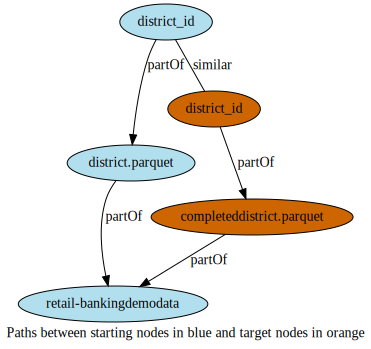

In [6]:
kglac.get_path_between_tables(enrichment_info.iloc[1], hops=1)

## **Using [Feast](https://docs.feast.dev/) as the feature store** 

  **Register feature definitions and deploy your feature store using <code>feast apply</code>** [(more info)](https://docs.feast.dev/getting-started/quickstart#step-3-register-feature-definitions-and-deploy-your-feature-store)


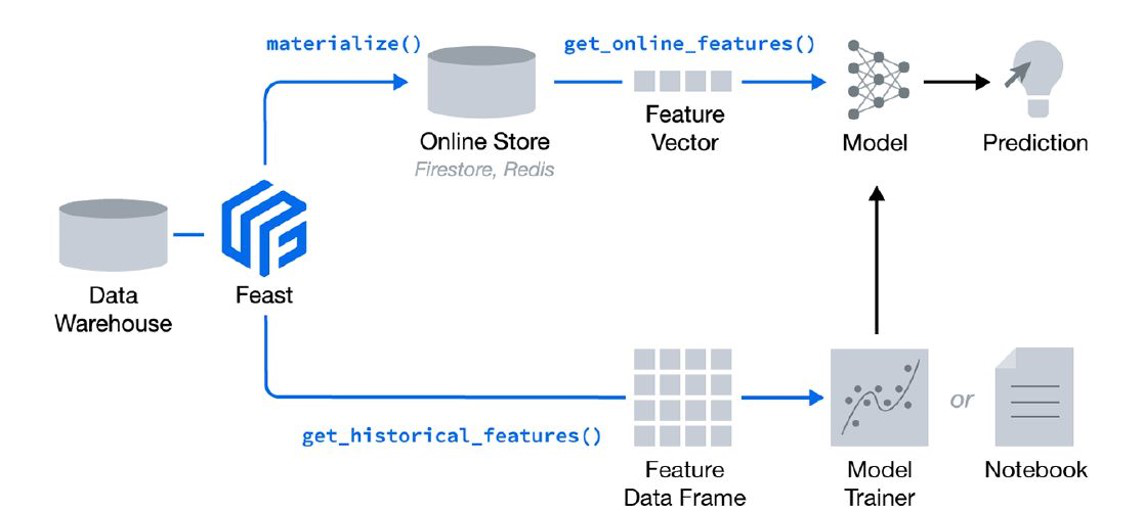

In [7]:
from feast import FeatureStore, FeatureService, FeatureView

os.chdir('feature_repo/')
!feast apply
os.chdir('../')
store = FeatureStore('feature_repo/')

Created entity client_id
Created entity account_id
Created entity district_id
Created feature view feature_view_1
Created feature view feature_view_2
Created feature view feature_view_3

Created sqlite table feature_repo_feature_view_1
Created sqlite table feature_repo_feature_view_2
Created sqlite table feature_repo_feature_view_3



3. **Automating feature retrival for [<code>get_historical_features</code>](https://docs.feast.dev/v/v0.6-branch/user-guide/feature-retrieval)** 






In [8]:
entity_df = pd.read_parquet(enrichment_info.iloc[1].Path_to_table)
entity_df

,district_id,event_timestamp
0,19,2022-05-06 09:15:12.093250
1,15,2022-05-08 05:46:51.093250
2,11,2022-05-10 07:02:00.093250
3,51,2022-05-10 07:09:48.093250
4,27,2022-05-10 05:42:05.093250
...,...,...
95,5,2022-05-05 01:31:44.093250
96,38,2022-05-06 04:58:18.093250
97,55,2022-05-04 11:29:53.093250
98,56,2022-05-02 11:11:02.093250


In [9]:
training_data = store.get_historical_features(
    features = kgfarm.get_features(enrichment_info.iloc[1]),
    entity_df = entity_df
).to_df()
training_data.sort_values('district_id').reset_index(drop=True)

,district_id,event_timestamp,city,state_name,state_abbrev,region,division,avg_sales,net_growth,return,n_customer_sat
0,1,2022-05-06 22:02:43.093250+00:00,New York City,New York,NY,Northeast,Middle Atlantic,1009007,4087,387,1
1,2,2022-05-09 13:26:41.093250+00:00,Jacksonville,Florida,FL,South,South Atlantic,753920,8044,275,1
2,3,2022-05-10 00:03:39.093250+00:00,Columbus,Ohio,OH,Midwest,East North Central,958201,7277,265,4
3,5,2022-05-04 18:33:17.093250+00:00,Indianapolis,Indiana,IN,Northeast,East North Central,604136,6885,804,3
4,5,2022-05-05 01:31:44.093250+00:00,Indianapolis,Indiana,IN,Northeast,East North Central,604136,6885,804,3
5,6,2022-05-07 22:39:41.093250+00:00,Seattle,Washington,WA,West,Pacific,615615,7247,116,4
6,6,2022-05-04 04:00:12.093250+00:00,Seattle,Washington,WA,West,Pacific,615615,7247,116,4
7,7,2022-05-04 02:21:33.093250+00:00,Denver,Colorado,CO,West,Mountain,947696,7632,736,1
8,10,2022-05-10 22:19:57.093250+00:00,Detroit,Michigan,MI,Midwest,East North Central,1382449,4938,123,4
9,11,2022-05-10 07:02:00.093250+00:00,Nashville,Tennessee,TN,South,East South Central,621761,7720,445,2


**Training a linear regression model**

In [10]:
features = [feature for feature in training_data.columns if feature not in 
['region', 'state_abbrev', 'city', 'state_name', 'division', 'event_timestamp', 'return']]
X = training_data[features].sort_index(axis=1).sort_values('district_id').reset_index(drop=True)
y = training_data['return']

model = LinearRegression()
model.fit(X, y)

LinearRegression()

**Materializing/loading features to online store using <code>feast masterialize</code>**  [(more info)](https://docs.feast.dev/getting-started/quickstart#step-5-load-features-into-your-online-store)

In [11]:
os.chdir('feature_repo/')
!feast materialize-incremental 2022-06-11
os.chdir('../')

Materializing 3 feature views to 2022-06-10 20:00:00-04:00 into the sqlite online store.

feature_view_1 from 2022-04-24 22:33:11-04:00 to 2022-06-10 20:00:00-04:00:
100%|█████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 2897.48it/s]
feature_view_2 from 2022-04-24 22:33:11-04:00 to 2022-06-10 20:00:00-04:00:
100%|█████████████████████████████████████████████████████████| 4500/4500 [00:01<00:00, 4146.81it/s]
feature_view_3 from 2022-04-24 22:33:12-04:00 to 2022-06-10 20:00:00-04:00:
100%|█████████████████████████████████████████████████████████| 5369/5369 [00:00<00:00, 9654.25it/s]


**Fetching feature vector(s) for inference using [<code>get_online_features</code>](https://docs.feast.dev/getting-started/quickstart#step-6-fetching-feature-vectors-for-inference)**

In [12]:
id = 10
feature_vector = store.get_online_features(
    features = kgfarm.get_features(enrichment_info.iloc[1]),
    entity_rows=[
        {'district_id': id}
    ],
).to_dict()

[feature_vector.pop(feature) for feature in list(feature_vector.keys()) if feature not in features]
feature_vector

{'district_id': [10],
 'net_growth': [4938],
 'avg_sales': [1382449],
 'n_customer_sat': [4]}

**Performing predictions in real-time!**

In [13]:
prediction = model.predict(pd.DataFrame(feature_vector).sort_index(axis=1))[0]
prediction

548.150057922904